# 👩‍🚀 Exploration 8. 인물 사진 재현하기 👩‍🚀

## 🎯 프로젝트 순서 🎯
- 이번 프로젝트는 셸로우 포커스를 기반으로 **인물 사진을 재현**하는 것입니다. 주요 순서는 아래와 같습니다!
1. 사진 준비하기
2. Segmentation으로 사람 분리하기
3. Semantic Segmentation 다루기
4. Segmentation 결과를 원래 크기로 복원하기
5. 배경 흐리게(Blur) 하기
6. 흐린 배경과 원본 이미지 합성하기
7. 고양이 사진에 적용하기
8. 배경 전환 크로마키 사진에 적용하기
9. 인물사진에서 발생한 문제 찾아내기
10. 다른 사물에 대해서도 할 수 있겠어요?
11. 인물모드 사진의 문제점에 대한 Solution
12. 프로젝트 전체 회고

- 프로젝트 순서 중 10번 내용은 **프로젝트에서 배운 내용을 기반으로 생각해 낸 프로젝트 내의 프로젝트**입니다.

## ✨ 1. 사진 준비하기 ✨

- 우선, **필요한 라이브러리를 import** 하겠습니다. 😊
- 아래 라이브러리들 중 **urllib은 웹에서 데이터를 다운로드할 때 사용**합니다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

- 이제 사진 준비하기 Step 전에 사전 준비한 이미지를 os와 cv2를 활용해 읽어오고, 이미지의 모양을 출력해보겠습니다.

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

(480, 640, 3)


## ✨ 2. Segmentation으로 사람 분리하기 ✨

- **이미지 세그멘테이션(Image Segmentation)** : 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법입니다.
- 이미지 세그멘테이션의 기본 가정 : **모든 픽셀에 라벨(label) 할당, 같은 라벨은 공통적 특징을 소유**
- **시멘틱 세그멘테이션(Semantic Segmentation)** : 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 말합니다.
- 시멘틱 세그멘테이션은 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적인 단위로 Classification 하는 방법이다.
- 시멘틱 세크멘테이션은 추상적인 정보를 이미지에서 추출해내는 방식입니다. 그 사람이 누구인지에 관계없이 같은 라벨로 표현됩니다.
- **인스턴스 세크멘테이션(Instance Segmentation)** : 여러 사람이 하나의 이미지에 등장하였을 때, 각 객체를 분할 인식하게 하는 것이 목표입니다.

## ✨ 3. Semantic Segmentation 다루기 ✨
- 우선 DeepLab 모델을 준비합니다.
- 구글에서 제공하는 모델 구조를 그대로 가져와 DeepLabModel 클래스를 만듭니다.
- **preprocess()** : 전처리 함수, **run()** : 실제 세그멘테이션을 하는 함수


### < 아래 코드 해석 >

- 입력 tensor를 만들기 위해 **preprocess() 함수에서 이미지 전처리**를 합니다.
- 모델이 받을 수 있는 입력 이미지의 크기는 정해져 있으므로 **적절한 resize** 과정을 거칩니다.
- Tensorflow를 활용하므로, **OpenCV의 디폴트인 BGR 형식을 RGB 형식으로 수정**해 줍니다.
- 이렇게 **전처리된 이미지를 run()의 입력값으로 사용**합니다.
- (참고) **tf.compat.v1** : Tensorflow V2에서 Tensorflow V1의 코드와 모델 구조를 활용할 수 있도록 도와줍니다.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- 이제, 구글에서 제공하는 **사전 학습된 가중치(pretained weight) 데이터를 불러오겠습니다.**
- 이 모델은 **PASCAL VOC 2012라는 대형 데이터셋**으로 학습되어 용량이 매우 큽니다. 따라서 모델 로드까지 꽤 시간이 걸립니다. ㅠㅠ

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


- 이전 스텝에서 준비한 이미지를 네트워크에 입력하겠습니다.
- 아래 코드에서 **seg_map.max()**는 세그멘테이션 맵에서 가장 큰 값, 쉽게 말하면 물체로 인식된 라벨 중 가장 큰 값을 말합니다.
- AIFFEL 노드에서는 seg_map.max() 값이 20이었는데, 저의 경우에는 15가 나왔습니다. 사진에 따라서 달라질 수 있겠습니다.

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(480, 640, 3) (384, 513, 3) 15


- 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다.
- 아래와 같은 라벨 종류가 존재하며, 제공됩니다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 우리의 목표는 사람과 배경을 분리시키는 것입니다.
- 여기서는 사람의 라벨 값인 15를 가진 영역만을 검출해내고자 합니다.
- 마스크를 만들고 시각화합니다.

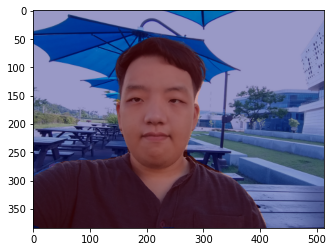

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### < 세그멘테이션 방법 >

- 사람을 나타내는 라벨(15) 이외의 예측은 모두 0으로 하였습니다.
- 예측된 segmentation map의 최댓값은 15가 됩니다.
- 위와 같이 일반적인 이미지는 픽셀을 0~255 까지 표현합니다.
- 세그멘테이션 맵에 포함된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화를 시킵니다.
- applyColorMap() 함수를 통해 색을 적용하여 이미지를 화면에 띄웁니다.

## ✨ 4. Segmentation 결과를 원래 크기로 복원하기 ✨

- 이미지 크기를 resize하는 이유는 DeepLab 모델을 원활히 사용하기 위함입니다.
- 세그멘테이션 결과(mask)를 원래 크기로 복원합니다.

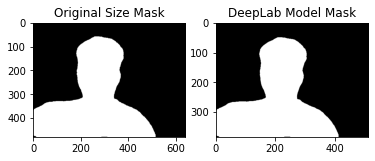

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### < 결과 해석 >
- 이미지의 크기를 키울 때는 **보간(interpolation)**을 고려하게 됩니다.
- **보간법(interpolation)** : 이미지의 크기를 scaling하는 과정에서 컴퓨터가 그 사이사이에 픽셀값을 채우는 방법
- 참고 링크 : https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html
- img_mask_up 은 경계가 Blur 된 픽셀 값 0~255의 이미지를 얻게 됩니다.
- 위의 코드와 같이 임계값(threshold)를 128로 설정했다면 128 이하의 값이면 검은색(0), 128 이상의 값은 흰색(255)을 적용하게 됩니다.

## ✨ 5. 배경 흐리게(Blur) 하기 ✨

- **blur()** 함수를 이용하여 배경을 흐리게 만들 수 있습니다.

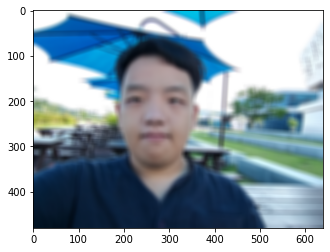

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- Segmentation Mask를 이용해, 흐려진 이미지에서 배경만 뽑아냅니다.
- **bitwise_not() 함수를 이용하면 이미지를 반전시킬 수 있습니다.** 이 경우 배경은 255, 사람은 0으로 인식됩니다.
- 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 우리가 원하는 부분을 얻을 수 있습니다.

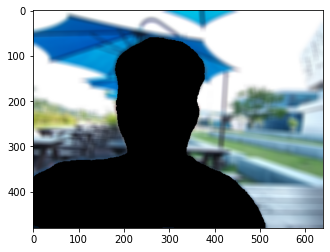

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## ✨ 6. 흐린 배경과 원본 이미지 합성하기 ✨

- 이제 배경과 사람을 합치면 됩니다.
- **Segmentation Mask의 값이 255인 부분만 원본을 적용**하고, 그 반대 영역에는 Blur 된 미지의 값을 사용하겠습니다.

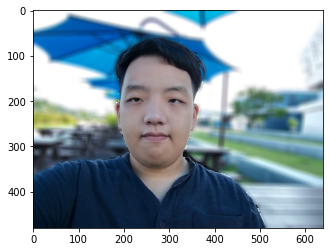

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 이제 원본과 비교해 보면 **인물 부분만 선명하게 나오는 것**을 확인할 수 있습니다!
- 아래는 배경이 blur 되지 않은 실배경 사진입니다.

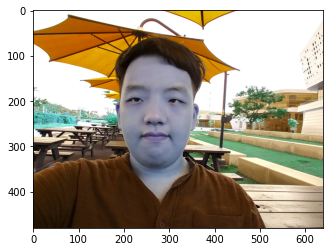

In [12]:
import os
my_image_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm.png'
img_rgb = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_rgb = cv2.resize(img_rgb, (640, 480))    # 640x360의 크기로 Resize
img_show = img_rgb.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_rgb)
plt.show()

- 이러한 기술을 다른 객체나 배경에도 적용할 수 있습니다.

## ✨ 7. 고양이 사진에 적용하기 ✨

- 앞선 1~6번까지의 방법을 활용하면 고양이 사진에 대해서도 배경을 Blur 후 객체를 강조하여 이미지를 표현해낼 수 있습니다.
- 여기서 달라지는 점은 이미지와 파일 이름, 파일 경로이다. 이 점을 참고하는 것이 좋겠습니다.

In [13]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imagecat.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

(480, 640, 3)


In [14]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(480, 640, 3) (384, 513, 3) 8


- 아까 LABEL_NAMES 리스트에서 cat이 해당하는 인덱스는 8이므로, 여기서는 인식 객체의 인덱스 값이 인물사진과는 다르다는 점에 주목합니다.

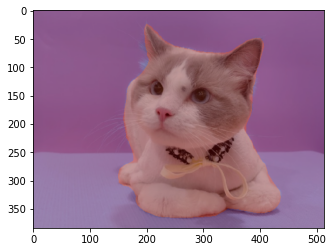

In [15]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 고양이(8)로 예측한 부분만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 원본의 배경은 분홍색 계열이었으나, cv2의 적용으로 배경 색이 파르스름하게 되는 것을 확인할 수 있습니다. (지금 프로젝트에선 상관 없지만)

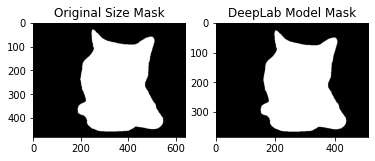

In [16]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

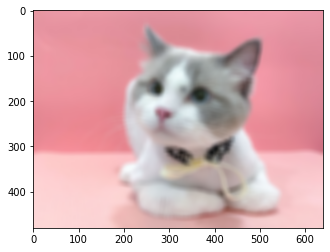

In [17]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

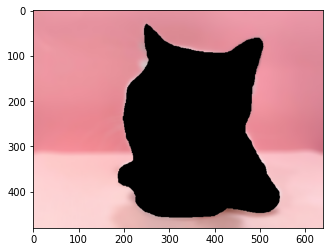

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
# plt.imshow(img_mask_color)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
# plt.imshow(img_bg_blur)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

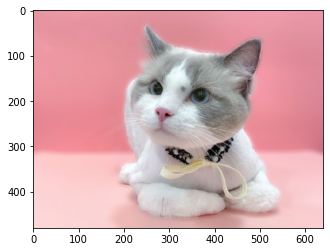

In [19]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## ✨ 8. 배경전환 크로마키 사진에 적용하기 ✨

- 이번 작업은 기존 이미지의 사람 부분을 떼어내어 전환된 다른 배경에 떼어낸 부분을 합성하는 작업입니다.
- 따라서 얼굴사진이 포함된 이미지 1장과 전환배경 이미지 1장으로 총 2장의 이미지가 필요합니다.

(4160, 3120, 3) (513, 384, 3) 15


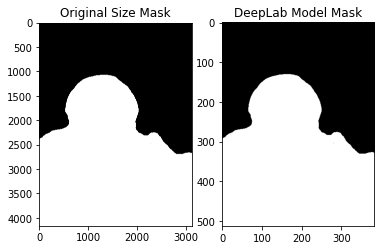

3120
4160
(4160, 3120, 3)
(4160, 3120, 3)


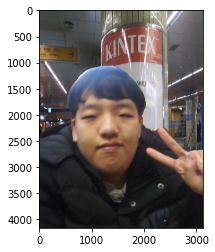

In [59]:
# path
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm7.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())


# image segmentation
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람 부분만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)


# image segmentation restore
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# new background path
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm6.jpg'
bg_orig = cv2.imread(bg_path)

# background resize 
target_size = (img_orig.shape[1], img_orig.shape[0]) # shape 맞추기
print(target_size[0]) # shape 확인
print(target_size[1]) # shape 확인
bg_resized = cv2.resize(bg_orig, target_size) # 이미지 resize를 위한 기준사진

print(img_orig.shape)
print(bg_resized.shape)

# concat
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## ✨ 9. 인물사진에서 발생한 문제 찾아내기 ✨

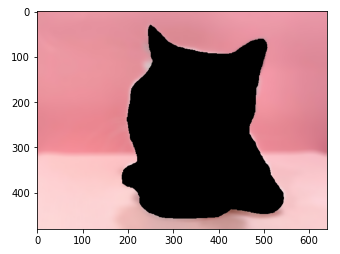

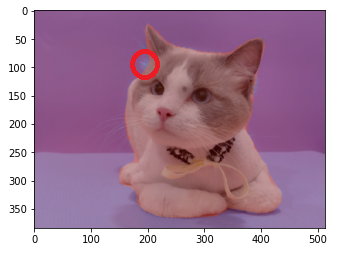

- 3가지 방법을 시도하면서 전체적으로 Segmentation을 하는 과정에서 크게 부위가 뚜렷하게 드러나지 않았거나 하는 부분은 발견하지 못했습니다.
- 굳이 찾아본다면 고양이 사진을 예로 들 수 있을 것 같습니다!

## ✨ 10. 다른 사물에 대해서도 할 수 있겠어요? ✨

- 이번에는 특별히 자전거(bicycle)만을 뽑아 내어 다른 사진에 크로마키 형식으로 합성해 보겠습니다.
- 우선, bicycle이 몇 번 index인지를 확인하기 위해.. 이것부터 시작하겠습니다.

In [60]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 위의 코드를 보시면 **LABEL_NAMES는 리스트 형식**을 취하고 있어서 각각이 **0번부터의 인덱스로 대응**됩니다.
- 그렇게 본다면 **bicycle은 2번 인덱스의 라벨 이름**이라는 것을 쉽게 알 수 있겠죠? 이것을 이용해보겠습니다.

(512, 512, 3) (513, 513, 3) 2


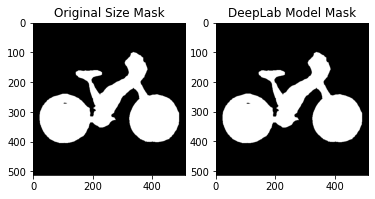

512
512
(512, 512, 3)
(512, 512, 3)


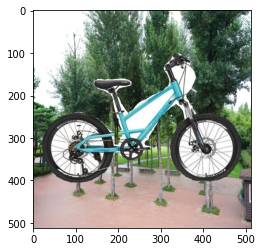

In [61]:
# path
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm14.jpg'
img_orig = cv2.imread(img_path) 

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())


# image segmentation
img_show = img_resized.copy()
seg_map = np.where(seg_map == 2, 2, 0) # 예측 중 자전거 부분만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)


# image segmentation restore
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

# new background path
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/imageksm13.jpg'
bg_orig = cv2.imread(bg_path)

# background resize 
target_size = (img_orig.shape[1], img_orig.shape[0]) # shape를 맞춥니다.
print(target_size[0]) # shape 확인
print(target_size[1]) # shape 확인
bg_resized = cv2.resize(bg_orig, target_size) # 이미지 resize를 위한 기준을 잡아봅니다.

print(img_orig.shape)
print(bg_resized.shape)

# concat
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 원래 자전거 사진입니다. 흰 바탕이 있었습니다.

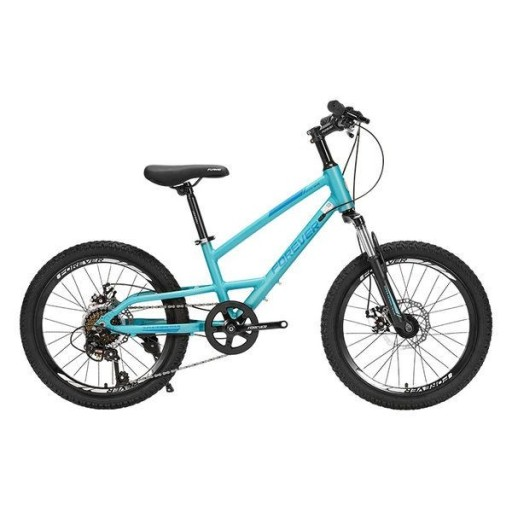

### Hoxy, 문제점은 발견했나요?

- 하얀 배경에 자전거가 배치되어 있는 사진을 가지고 다른 배경에 합성을 진행했습니다.
- 세우고자 하는 배경에 자전거를 합성하는 것은 성공적이었습니다.
- 하지만 모양 사이사이에 흰색의 배경 조각이 같이 합성되어서 온전히 자전거를 합성하지는 못한 것 같습니다.
- 추가적으로 오른쪽 타이어 아랫부분이 살짝 잘려서 나온 부분도 발견했습니다.
- 자전거 사진과 비교했을 때 사람, 고양이 등은 자전거처럼 모양 사이에 틈이 있지 않아서 대체로 완벽하게 다른 배경에 합성을 할 수 있었습니다.

## ✨ 11. 인물모드 사진의 문제점에 대한 Solution ✨

- 아래 링크는, 인물모드 사진을 조금 더 내가 원하는 방향으로 정교하게 분리하는 방법이 소개되어 있습니다.
https://devkor.tistory.com/entry/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%9D%84-%ED%86%B5%ED%95%9C-Image-Segmentation-%EC%9E%85%EB%AC%B8
- 간단히 요약하면 FCN의 Skip Combining 기법을 활용해서 더욱 정교하게 내가 원하는 부분을 표현할 수 있다는 점..?

## ✨ 12. 프로젝트 전체 회고 ✨

- 이번 프로젝트는 Image Segmentation 기법을 활용해서 인물이나 사물을 부각시키거나 다른 배경에 잘라낸 인물이나 사물을 합성시키는 방법을 알아본 CV 분야의 프로젝트였습니다.
- 프로젝트 순서 10번을 하기 전까지는 합성 과정을 수행하면서 결함이나 문제점을 발견하지 못해서 다른 인물이나 사물로 다시 해 보려고 추가로 **자전거를 선정하여 프로젝트를 진행**했습니다.
- 자전거를 매개로 한 합성에서는 **자전거 모양 사이사이에 '틈'이라는 것이 존재했기 때문에 이전의 사람이나 고양이와는 달리 완벽한 자전거의 모습으로 다른 배경에 합성을 잘 하지 못했음**을 알 수 있었습니다.
- 이미지를 보다 정교하고 효과적으로 편집하는 방법을 알게 된다면, 더 생동감 있게 이미지를 표현해낼 수 있지 않을까 생각해봅니다! 😙😙